### Case Study #1 - Danny's Diner

https://8weeksqlchallenge.com/case-study-1/



<h2> Entity Relationship Diagram </h2>

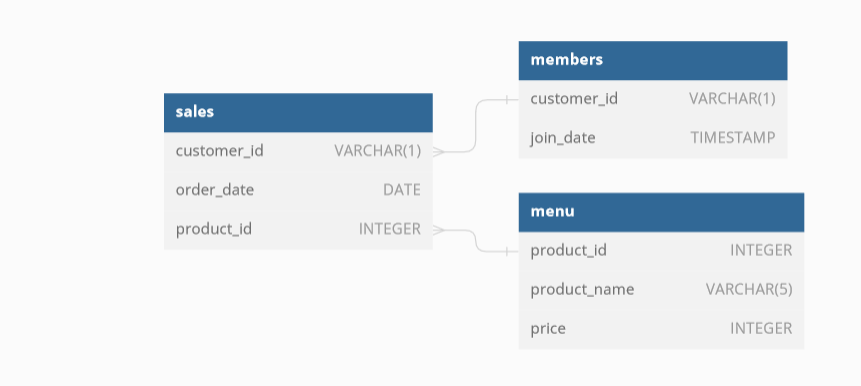

<h2> Case Study Questions </h2>
Each of the following case study questions can be answered using a single SQL statement:

1. What is the total amount each customer spent at the restaurant?
2. How many days has each customer visited the restaurant?
3. What was the first item from the menu purchased by each customer?
4. What is the most purchased item on the menu and how many times was it purchased by all customers?
5. Which item was the most popular for each customer?
6. Which item was purchased first by the customer after they became a member?
7. Which item was purchased just before the customer became a member?
8. What is the total items and amount spent for each member before they became a member?
9. If each $1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?
10. In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January?

In [1]:
import sqlite3
import pprint
import pandas as pd

In [2]:
db = sqlite3.connect(":memory:")

In [3]:
cur = db.cursor()

In [4]:
def execute_query(query):
    cur.execute(query)
    desp = cur.description
    if desp:
        cols = [ele[0] for ele in desp if ele]
        for row in cur:
            pprint.pprint(dict(zip(cols, row)))

In [5]:
def execute_query_pd(query):
    print(pd.read_sql_query(query, db))

In [6]:
queries_list = [
    """
      CREATE TABLE sales (
      "customer_id" VARCHAR(1),
      "order_date" DATE,
      "product_id" INTEGER
    );
    """,

"""INSERT INTO sales
  ("customer_id", "order_date", "product_id")
VALUES
  ('A', '2021-01-01', '1'),
  ('A', '2021-01-01', '2'),
  ('A', '2021-01-07', '2'),
  ('A', '2021-01-10', '3'),
  ('A', '2021-01-11', '3'),
  ('A', '2021-01-11', '3'),
  ('B', '2021-01-01', '2'),
  ('B', '2021-01-02', '2'),
  ('B', '2021-01-04', '1'),
  ('B', '2021-01-11', '1'),
  ('B', '2021-01-16', '3'),
  ('B', '2021-02-01', '3'),
  ('C', '2021-01-01', '3'),
  ('C', '2021-01-01', '3'),
  ('C', '2021-01-07', '3');""",
 

"""CREATE TABLE menu (
  "product_id" INTEGER,
  "product_name" VARCHAR(5),
  "price" INTEGER
);""",

"""INSERT INTO menu
  ("product_id", "product_name", "price")
VALUES
  ('1', 'sushi', '10'),
  ('2', 'curry', '15'),
  ('3', 'ramen', '12');""",
  

"""CREATE TABLE members (
  "customer_id" VARCHAR(1),
  "join_date" DATE
);""",

"""INSERT INTO members
  ("customer_id", "join_date")
VALUES
  ('A', '2021-01-07'),
  ('B', '2021-01-09');"""
]

for q in queries_list:
    execute_query(q)

In [7]:
# What is the total amount each customer spent at the restaurant?
query = """
    SELECT CUSTOMER_ID, 
           SUM(PRICE) AS TOTAL_AMOUNT
    FROM SALES
    INNER JOIN MENU
    ON SALES.PRODUCT_ID = MENU.PRODUCT_ID
    GROUP BY CUSTOMER_ID
"""
execute_query(query)

{'TOTAL_AMOUNT': 76, 'customer_id': 'A'}
{'TOTAL_AMOUNT': 74, 'customer_id': 'B'}
{'TOTAL_AMOUNT': 36, 'customer_id': 'C'}


In [8]:
# How many days has each customer visited the restaurant?
query = """
    SELECT CUSTOMER_ID,
           COUNT(DISTINCT ORDER_DATE) AS VISITED
    FROM SALES
    GROUP BY CUSTOMER_ID
    ORDER BY VISITED DESC
"""
execute_query(query)

{'VISITED': 6, 'customer_id': 'B'}
{'VISITED': 4, 'customer_id': 'A'}
{'VISITED': 2, 'customer_id': 'C'}


In [9]:
# What was the first item from the menu purchased by each customer?
query = """
    WITH RANK_TBL AS (
        SELECT CUSTOMER_ID,
               PRODUCT_NAME,
               RANK() OVER (PARTITION BY CUSTOMER_ID ORDER BY ORDER_DATE) AS RNK
        FROM SALES
        INNER JOIN MENU
        ON SALES.PRODUCT_ID = MENU.PRODUCT_ID
        )
    SELECT CUSTOMER_ID, PRODUCT_NAME
    FROM RANK_TBL
    WHERE RNK = 1
    GROUP BY CUSTOMER_ID, PRODUCT_NAME
"""
execute_query(query)

{'CUSTOMER_ID': 'A', 'PRODUCT_NAME': 'curry'}
{'CUSTOMER_ID': 'A', 'PRODUCT_NAME': 'sushi'}
{'CUSTOMER_ID': 'B', 'PRODUCT_NAME': 'curry'}
{'CUSTOMER_ID': 'C', 'PRODUCT_NAME': 'ramen'}


In [10]:
# What is the most purchased item on the menu and how many times was it purchased by all customers?
query ="""
    SELECT PRODUCT_NAME,
           COUNT(MENU.PRODUCT_ID) AS TOTAL_PURCHASES
    FROM SALES
    INNER JOIN MENU
    ON SALES.PRODUCT_ID = MENU.PRODUCT_ID
    GROUP BY PRODUCT_NAME
    ORDER BY TOTAL_PURCHASES DESC
    LIMIT 1
"""
execute_query(query)

{'TOTAL_PURCHASES': 8, 'product_name': 'ramen'}


In [11]:
# Which item was the most popular for each customer?
query = """
    WITH RANK_TBL AS (
            SELECT CUSTOMER_ID,
                   PRODUCT_NAME,
                   COUNT(PRODUCT_NAME)  AS TOTAL_PURCHASES,
                   rank() over(partition by customer_id order by count(product_name) desc) as RNK
            FROM SALES
            INNER JOIN MENU
            ON SALES.PRODUCT_ID = MENU.PRODUCT_ID
            GROUP BY CUSTOMER_ID, PRODUCT_NAME
            ORDER BY CUSTOMER_ID
                    )
    SELECT CUSTOMER_ID,
           PRODUCT_NAME,
           TOTAL_PURCHASES
    FROM RANK_TBL
    WHERE RNK = 1
"""

execute_query(query)

{'CUSTOMER_ID': 'A', 'PRODUCT_NAME': 'ramen', 'TOTAL_PURCHASES': 3}
{'CUSTOMER_ID': 'B', 'PRODUCT_NAME': 'sushi', 'TOTAL_PURCHASES': 2}
{'CUSTOMER_ID': 'B', 'PRODUCT_NAME': 'ramen', 'TOTAL_PURCHASES': 2}
{'CUSTOMER_ID': 'B', 'PRODUCT_NAME': 'curry', 'TOTAL_PURCHASES': 2}
{'CUSTOMER_ID': 'C', 'PRODUCT_NAME': 'ramen', 'TOTAL_PURCHASES': 3}


In [12]:
# Which item was purchased first by the customer after they became a member?

query = """
        WITH RANK_TBL as (
            SELECT S.CUSTOMER_ID,
                   S.PRODUCT_ID,
                   rank() over(partition by s.customer_id order by order_date) as rnk
            from sales as s
            inner join members as m
            on s.customer_id = m.customer_id
            where s.order_date >= m.join_date
        )
        select customer_id,
               product_name
        from RANK_TBL as t
        inner join menu
        on t.product_id = menu.product_id
        where t.rnk = 1
    """
execute_query(query)

{'CUSTOMER_ID': 'B', 'product_name': 'sushi'}
{'CUSTOMER_ID': 'A', 'product_name': 'curry'}


In [13]:
# Which item was purchased just before the customer became a member?

query = """
        with RANK_TBL as (
            select S.CUSTOMER_ID,
                   S.PRODUCT_ID,
                   rank() over(partition by s.customer_id order by order_date desc) as rnk
            from sales as s
            inner join members as m
            on s.customer_id = m.customer_id
            where s.order_date < m.join_date
        )
        select customer_id,
               product_name
        from RANK_TBL as t
        inner join menu
        on t.product_id = menu.product_id
        where t.rnk = 1
"""
execute_query(query)

{'CUSTOMER_ID': 'A', 'product_name': 'sushi'}
{'CUSTOMER_ID': 'B', 'product_name': 'sushi'}
{'CUSTOMER_ID': 'A', 'product_name': 'curry'}


In [14]:
# What is the total items and amount spent for each member before they became a member?

query = """
        select s.customer_id,
               count(product_name) as total_items,
               sum(price) as amount_spent
        from sales s
        inner join menu
        on s.product_id = menu.product_id
        inner join members as m
        on s.customer_id = m.customer_id
        where s.order_date < m.join_date
        group by s.customer_id
"""
execute_query(query)

{'amount_spent': 25, 'customer_id': 'A', 'total_items': 2}
{'amount_spent': 40, 'customer_id': 'B', 'total_items': 3}


In [15]:
# If each $1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?

query = """
    select customer_id,
           sum(case when product_name = 'sushi' then 2 * 10 * m.price
                    else 10 * m.price end
                ) as total_points
    from sales as s
    inner join menu as m
    on s.product_id = m.product_id
    group by customer_id
"""
execute_query(query)

{'customer_id': 'A', 'total_points': 860}
{'customer_id': 'B', 'total_points': 940}
{'customer_id': 'C', 'total_points': 360}


In [16]:
# In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January?

query = """
    select 
        s.customer_id, 
        sum(case when product_name = 'sushi' then 2*10*price
                 when order_date between join_date and date(join_date, '+6 days') then 2*10*price
                 else 10*price END
              ) as total
    from sales s
    inner join members m
    on s.customer_id = m.customer_id
    inner join menu
    on menu.product_id = s.product_id
    where cast(strftime("%m", order_date) as int) = 1
    group by s.customer_id
"""
execute_query(query)

{'customer_id': 'A', 'total': 1370}
{'customer_id': 'B', 'total': 820}


In [17]:
# Join All The Things

query = """
SELECT SALES.customer_id,
       SALES.order_date,
       MENU.product_name, MENU.price,
       CASE WHEN SALES.ORDER_DATE >= MEMBERS.JOIN_DATE THEN 'Y'
            ELSE 'N'
       END AS member
FROM SALES
INNER JOIN MENU
ON SALES.PRODUCT_ID = MENU.PRODUCT_ID
LEFT JOIN MEMBERS
ON SALES.CUSTOMER_ID = MEMBERS.CUSTOMER_ID

"""
execute_query_pd(query)

   customer_id  order_date product_name  price member
0            A  2021-01-01        sushi     10      N
1            A  2021-01-01        curry     15      N
2            A  2021-01-07        curry     15      Y
3            A  2021-01-10        ramen     12      Y
4            A  2021-01-11        ramen     12      Y
5            A  2021-01-11        ramen     12      Y
6            B  2021-01-01        curry     15      N
7            B  2021-01-02        curry     15      N
8            B  2021-01-04        sushi     10      N
9            B  2021-01-11        sushi     10      Y
10           B  2021-01-16        ramen     12      Y
11           B  2021-02-01        ramen     12      Y
12           C  2021-01-01        ramen     12      N
13           C  2021-01-01        ramen     12      N
14           C  2021-01-07        ramen     12      N


In [18]:
# Rank All The Things

query = """
    WITH TBL AS (
        SELECT SALES.customer_id,
               SALES.order_date,
               MENU.product_name, MENU.price,
               CASE WHEN SALES.ORDER_DATE >= MEMBERS.JOIN_DATE THEN 'Y'
                    ELSE 'N'
               END AS member
        FROM SALES
        INNER JOIN MENU
        ON SALES.PRODUCT_ID = MENU.PRODUCT_ID
        LEFT JOIN MEMBERS
        ON SALES.CUSTOMER_ID = MEMBERS.CUSTOMER_ID
        )
    SELECT *,
           CASE WHEN MEMBER = 'Y' THEN DENSE_RANK() OVER(PARTITION BY CUSTOMER_ID, MEMBER ORDER BY ORDER_DATE)
                ELSE NULL
            END AS RANKING
    FROM TBL
"""
execute_query_pd(query)

   customer_id  order_date product_name  price member  RANKING
0            A  2021-01-01        sushi     10      N      NaN
1            A  2021-01-01        curry     15      N      NaN
2            A  2021-01-07        curry     15      Y      1.0
3            A  2021-01-10        ramen     12      Y      2.0
4            A  2021-01-11        ramen     12      Y      3.0
5            A  2021-01-11        ramen     12      Y      3.0
6            B  2021-01-01        curry     15      N      NaN
7            B  2021-01-02        curry     15      N      NaN
8            B  2021-01-04        sushi     10      N      NaN
9            B  2021-01-11        sushi     10      Y      1.0
10           B  2021-01-16        ramen     12      Y      2.0
11           B  2021-02-01        ramen     12      Y      3.0
12           C  2021-01-01        ramen     12      N      NaN
13           C  2021-01-01        ramen     12      N      NaN
14           C  2021-01-07        ramen     12      N  